In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Using Tensorflow and Keras to predict house prices using a .csv file of house data

![Alt text](https://junwin.github.io/assets/Z01.jpeg)

This walkthrough shows the process of using deep learning to predict house prices using Tensorflow, Keras and a .csv file of sales data.

The topics covered are:

* Loading data from a .csv
* splitting data into training, validation and test sets
* Handling mixed types of data
* Normalising data
* Handling categorical features
* Creating a deep learning model
* Analysing the results
* Storing and reloading models


Kaggle dataset - https://www.kaggle.com/datasets/shree1992/housedata?resource=download 


## Acknowledgement 
This short walkthrough borrows from the excellent tutorial on loading .csv files using Keras.  
https://www.tensorflow.org/tutorials/load_data/csv

## Setup

In [1]:
import pandas as pd
import numpy as np

# Make numpy values easier to read.
np.set_printoptions(precision=3, suppress=True)

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import regularizers
#from sklearn import preprocessing
from sklearn.model_selection import train_test_split

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

import os
os.chdir("/content/drive/My Drive/Colab Notebooks/zillow_models/archive")

data = pd.read_csv('data.csv')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [3]:
# Example Data
#data.sample(6)
housePrices=data.sample(frac=1)
housePrices.pop('country')
housePrices.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip
2618,2014-06-16 00:00:00,492500.0,5.0,2.5,2570,9962,2.0,0,0,3,2570,0,2006,0,14206 284th Pl NE,Duvall,WA 98019
1230,2014-05-23 00:00:00,306000.0,2.0,1.0,780,13500,1.0,0,0,4,780,0,1946,1989,15210 Mink Rd NE,Woodinville,WA 98077
2649,2014-06-17 00:00:00,547000.0,4.0,1.0,1720,2800,1.5,0,0,4,1200,520,1926,1993,6211 27th Ave NE,Seattle,WA 98115
4559,2014-06-29 00:00:00,464600.0,2.0,1.0,840,3400,1.0,0,2,4,840,0,1924,0,2423 11th Ave W,Seattle,WA 98119
897,2014-05-19 00:00:00,373000.0,3.0,2.5,1670,3565,2.0,0,0,3,1670,0,1999,0,18581 134th Pl NE,Woodinville,WA 98072


## Loading data from a .csv
The size of the sales data is relatively small, so we can process it in memory. We will use a Pandas dataframe to do any manipulation.

In [ ]:
# import own csv file 
#url="https://junwin.github.io/data/housepriceclean2.csv" 
housePrices=pd.read_csv(url).sample(frac=1)
# We will not process the ClosedDate column - so remove it
housePrices.pop('ClosedDate')
housePrices.head()

A benefit of using Pandas is that it is easy to experiment with the data, for example, to select some subset while to help understand what affects the accuracy of the model.


In [ ]:
#housePrices = housePrices.loc[(housePrices['Zip'] == 60076) & (housePrices['Type'] == 'SFH')]

In our processing, we will treat strings as categories. Although Zip code is numeric, we cannot treat it as a number in the model, so let's convert it to a string.

In [4]:
housePrices['city'] = housePrices['city'].astype(str) 
housePrices.dtypes

date              object
price            float64
bedrooms         float64
bathrooms        float64
sqft_living        int64
sqft_lot           int64
floors           float64
waterfront         int64
view               int64
condition          int64
sqft_above         int64
sqft_basement      int64
yr_built           int64
yr_renovated       int64
street            object
city              object
statezip          object
dtype: object

We now split the data loaded from the .csv into 
three sets ( training data, validation data and test data).

In [5]:
train, test = train_test_split(housePrices, test_size=0.2)
train, val = train_test_split(train, test_size=0.2)
print(len(train), 'train examples')
print(len(val), 'validation examples')
print(len(test), 'test examples')


2944 train examples
736 validation examples
920 test examples


Next, we will separate the training and validation dataframes into features and targets and do a rough normalisation of price.

In [6]:
housePrices_features = train.copy()
housePrices_labels = housePrices_features.pop('price')
housePrices_labels = housePrices_labels/100000

val_features = val.copy()
val_labels = val.pop('price')
val_labels = val_labels/100000

In [7]:
print(housePrices_features.dtypes)
print(housePrices_labels.dtypes)

date              object
bedrooms         float64
bathrooms        float64
sqft_living        int64
sqft_lot           int64
floors           float64
waterfront         int64
view               int64
condition          int64
sqft_above         int64
sqft_basement      int64
yr_built           int64
yr_renovated       int64
street            object
city              object
statezip          object
dtype: object
float64


It is difficult to use the data we have to train a model "as is" because the feature data contains different types and numeric ranges.

It is possible to write code to transform the original dataset; however, we would need to consider deploying the extra code. Second, when using the model to predict a price, we will need to use the same transformations on the data input.

A reasonable solution is to embed any transformations into the model, so it is simple to deploy and use.

Here we will build a model using the Keras functional API the functional API uses symbolic tensors so we will first create a set of these tensors matching the names and types of the feature data.



In [8]:
inputs = {}

for name, column in housePrices_features.items():
  dtype = column.dtype
  if dtype == object:
    dtype = tf.string
  else:
    dtype = tf.float32

  inputs[name] = tf.keras.Input(shape=(1,), name=name, dtype=dtype)

inputs

{'date': <KerasTensor: shape=(None, 1) dtype=string (created by layer 'date')>,
 'bedrooms': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'bedrooms')>,
 'bathrooms': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'bathrooms')>,
 'sqft_living': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'sqft_living')>,
 'sqft_lot': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'sqft_lot')>,
 'floors': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'floors')>,
 'waterfront': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'waterfront')>,
 'view': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'view')>,
 'condition': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'condition')>,
 'sqft_above': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'sqft_above')>,
 'sqft_basement': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'sqft_basement')>,
 'yr_built': <

In [ ]:
#print(housePrices_features.dtypes)
print(housePrices_labels.dtypes)

float64


We will use Tensorflow's normalization pre-processing for each numeric field. Notice that we call the adapt method with the training data to set up the normaliser before use.

In [9]:
numeric_inputs = {name:input for name,input in inputs.items()
                  if input.dtype==tf.float32}

x = layers.Concatenate()(list(numeric_inputs.values()))
norm = preprocessing.Normalization()
norm.adapt(np.array(housePrices[numeric_inputs.keys()]))
all_numeric_inputs = norm(x)

all_numeric_inputs

<KerasTensor: shape=(None, 12) dtype=float32 (created by layer 'normalization')>

Collect all the symbolic preprocessing results, to concatenate them later.

In [10]:
preprocessed_inputs = [all_numeric_inputs]

String fields will first use a StringLookup function to map the strings to their corresponding index in a vocabulary based on the different data strings. Second, using the index and default settings, the Tensorflow's pre-processing category encoding will generate a one-hot vector.

Together with the numeric field handling, we then transform the input data.

In [11]:
for name, input in inputs.items():
  if input.dtype == tf.float32:
    continue
  
  lookup = preprocessing.StringLookup(vocabulary=np.unique(housePrices_features[name]))
  one_hot = preprocessing.CategoryEncoding(num_tokens=lookup.vocabulary_size())

  x = lookup(input)
  x = one_hot(x)
  preprocessed_inputs.append(x)

Given the preprocessed inputs (for normalisation and categorisation) and the corresponding input fields we can build a model the preprocesses the input data. We can visualise the model, as shown below.

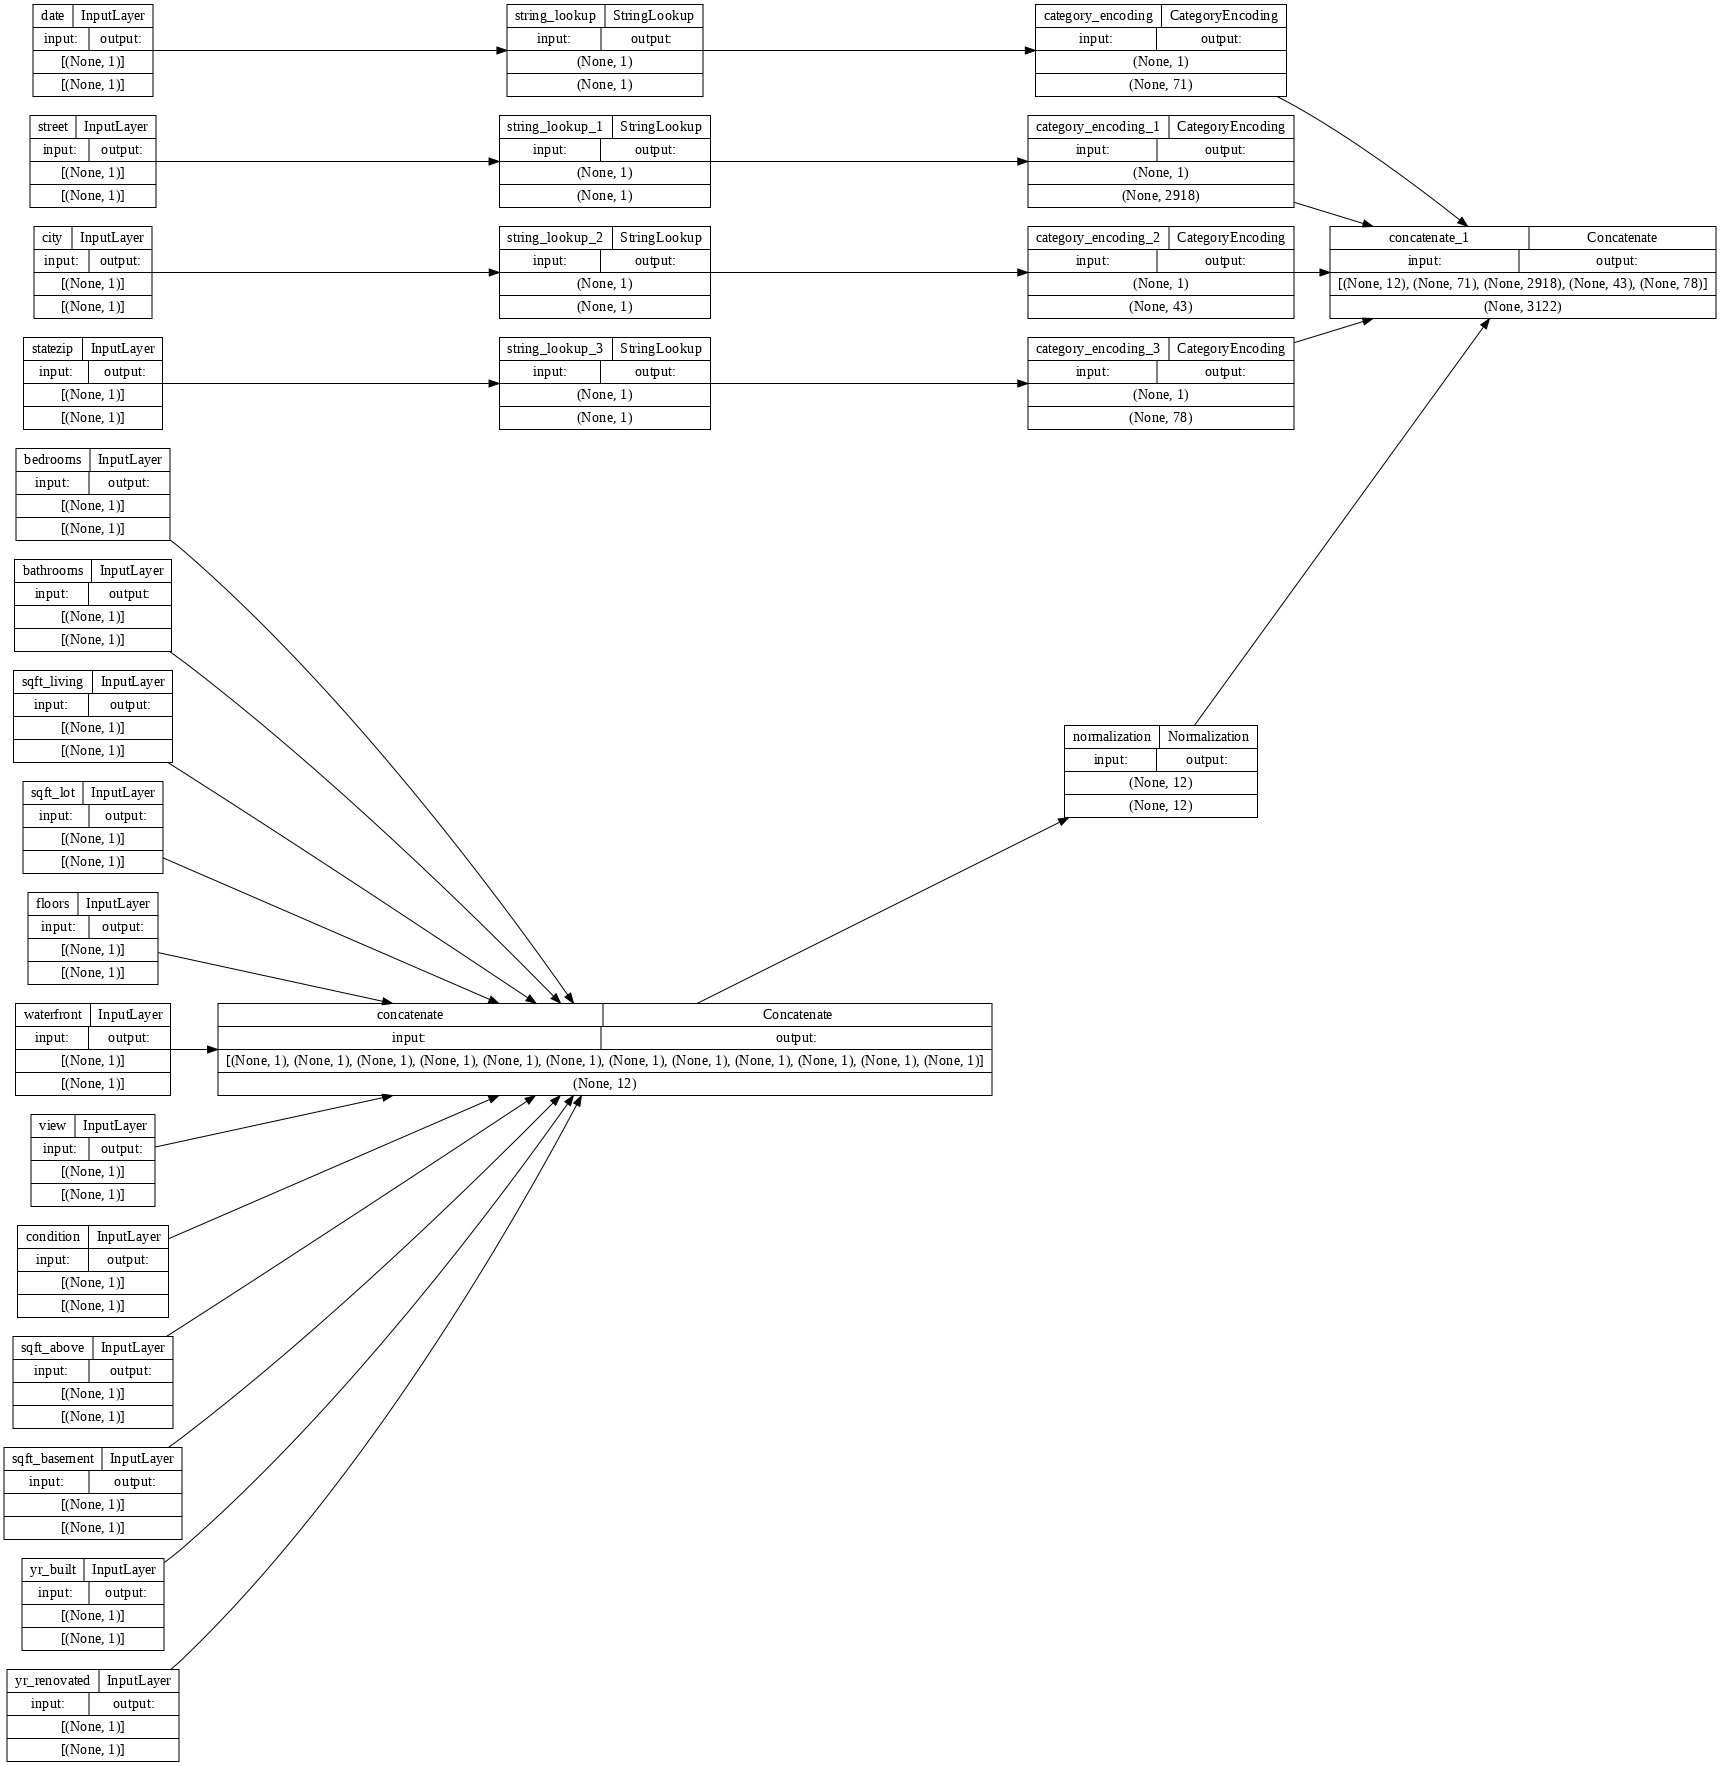

In [12]:
preprocessed_inputs_cat = layers.Concatenate()(preprocessed_inputs)

housePrices_preprocessing = tf.keras.Model(inputs, preprocessed_inputs_cat)

tf.keras.utils.plot_model(model = housePrices_preprocessing , rankdir="LR", dpi=72, show_shapes=True)

This `model` just contains the input preprocessing. You can run it to see what it does to your data. Keras models don't automatically convert Pandas `DataFrames` because it's not clear if it should be converted to one tensor or to a dictionary of tensors. So convert it to a dictionary of tensors:

In [13]:
housePrices_features_dict = {name: np.array(value) 
                         for name, value in housePrices_features.items()}

#housePrices_features.head()

We can run some sample data through the preprocessing, to validate we are getting the expected results - you should be able to see the normalised data and one-hot vectors.

In [14]:
features_dict = {name:values[:1] for name, values in housePrices_features_dict.items()}
housePrices_preprocessing(features_dict)

<tf.Tensor: shape=(1, 3122), dtype=float32, numpy=array([[0.659, 0.433, 0.925, ..., 0.   , 0.   , 0.   ]], dtype=float32)>

Now build the model based on the Keras functional API  on top of this.
We will typically make changes to the layers defined in the housePrices_model function. In this case, a pipeline is built that takes the inputs, pre-processes them and then uses the main model to make predictions.

In [27]:
def housePrices_model(preprocessing_head, inputs):
  body = tf.keras.Sequential([
    layers.Dense(128,activation='softmax', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(64,activation='relu'),
    layers.Dense(32,activation='relu'),
    layers.Dense(16,activation='relu'),
    layers.Dense(1)
  ])

  preprocessed_inputs = preprocessing_head(inputs)
  result = body(preprocessed_inputs)
  model = tf.keras.Model(inputs, result)

  model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['mae'])
  return model

housePrices_model = housePrices_model(housePrices_preprocessing, inputs)

When you train the model, pass the dictionary of features as `x`, and the label as `y`.

In [28]:
val_features_dict = {name: np.array(value) 
                         for name, value in val.items()}
history_1 = housePrices_model.fit(x=housePrices_features_dict, y=housePrices_labels,epochs=200,
                        validation_data=(val_features_dict, val_labels))

Epoch 1/200
92/92 [==============================] - 2s 10ms/step - loss: 66.9894 - mae: 4.8714 - val_loss: 18.9127 - val_mae: 2.8179
Epoch 2/200
92/92 [==============================] - 1s 7ms/step - loss: 41.8086 - mae: 2.3743 - val_loss: 9.0136 - val_mae: 2.0031
Epoch 3/200
92/92 [==============================] - 1s 6ms/step - loss: 37.4847 - mae: 1.9060 - val_loss: 6.5620 - val_mae: 1.6263
Epoch 4/200
92/92 [==============================] - 1s 6ms/step - loss: 35.3415 - mae: 1.5520 - val_loss: 5.5609 - val_mae: 1.3354
Epoch 5/200
92/92 [==============================] - 1s 6ms/step - loss: 34.1555 - mae: 1.3588 - val_loss: 5.1742 - val_mae: 1.2427
Epoch 6/200
92/92 [==============================] - 1s 6ms/step - loss: 33.3924 - mae: 1.2201 - val_loss: 4.9823 - val_mae: 1.2080
Epoch 7/200
92/92 [==============================] - 1s 6ms/step - loss: 32.7468 - mae: 1.1534 - val_loss: 4.8188 - val_mae: 1.1662
Epoch 8/200
92/92 [==============================] - 1s 6ms/step - loss: 3

1s 6ms/step - loss: 0.3923 - mae: 0.2084 - val_loss: 7.2911 - val_mae: 1.2940

It is crucial to visualise the metrics produced during training; this will quickly indicate how quickly the model converges, potential issues of under and overfitting.

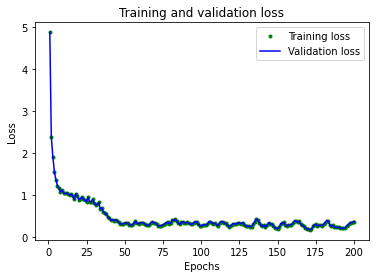

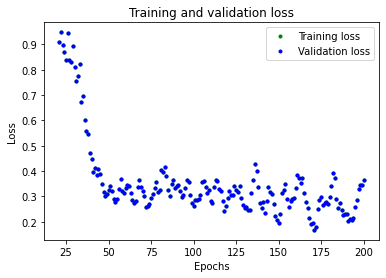

In [29]:
# Draw a graph of the loss, which is the distance between
# the predicted and actual values during training and validation.
import matplotlib.pyplot as plt
train_loss = history_1.history['mae']
val_loss = history_1.history['mae']
epochs = range(1, len(train_loss) + 1)

plt.plot(epochs, train_loss, 'g.', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Exclude the first few epochs so the graph is easier to read
SKIP = 20

plt.plot(epochs[SKIP:], train_loss[SKIP:], 'g.', label='Training loss')
plt.plot(epochs[SKIP:], val_loss[SKIP:], 'b.', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

By implementing pre-processing as part of the model, we can now save the model and deploy it elsewhere as a simple package. 

In [30]:
housePrices_model.save('test')
reloaded = tf.keras.models.load_model('test')

In [31]:
! zip -r test.zip test 

  adding: test/ (stored 0%)
  adding: test/variables/ (stored 0%)
  adding: test/variables/variables.data-00000-of-00001 (deflated 6%)
  adding: test/variables/variables.index (deflated 65%)
  adding: test/assets/ (stored 0%)
  adding: test/saved_model.pb (deflated 85%)
  adding: test/keras_metadata.pb (deflated 77%)


In [32]:
features_dict = {name:values[:1] for name, values in housePrices_features_dict.items()}

before = housePrices_model(features_dict)
after = reloaded(features_dict)
assert (before-after)<1e-3
print(before)
print(after)

tf.Tensor([[10.658]], shape=(1, 1), dtype=float32)
tf.Tensor([[10.658]], shape=(1, 1), dtype=float32)


Finally, we can run predictions on our own data.
Use homes from zillow.com 

In [ ]:
hoiseData_own01 = {'bedrooms': np.array([]),
                   'bathrooms': np.array([]),
                   'sqft_living': np.array([]),
                   'sqft_lot': np.array([]),
                   'floors': np.array([]),
                   'waterfront': np.array([]),
                   'view': np.array([]),
                   'condition': np.array([]),
                   'sqft_above': np.array([]),
                   'sqft_basement': np.array([]),
                   'yr_built': np.array([]),
                   'city': np.array([]),
                   'statezip': np.array([]),}

In [ ]:


houseData_own2 = {'Type': np.array(['SFH', 'SFH', 'SFH', 'Condo', 'Condo']),
  'houseEra': np.array(['recent', '19A', '20A', '20A', '19B']),
	'Area': np.array([8410, 1400, 1500, 1500, 1600]),
  'Zip': np.array(['60062', '60062', '60076', '60076', '60202']),
	'Rooms': np.array([16, 6, 7, 7, 7]),
  'FullBaths': np.array([6.0, 2.0, 2.0, 2.5, 2.0]),
  'HalfBaths': np.array([0.0, 1.0, 1.0, 0.0, 0.0]),
  'BsmtBth': np.array(['Yes', 'No', 'No', 'No', 'No']),
  'Beds': np.array([5, 3, 3, 3, 3]),
  'BsmtBeds': np.array([1.0, 0.0, 0.0, 0.0, 0.0]),
  'GarageSpaces': np.array([3, 2, 0, 0, 0])  }

ans = reloaded.predict(houseData_own2)

print(ans)

